# **Выводы в конце ноутбука:** 

In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn 
import torch.nn.functional as F

In [ ]:
# Generator
class Generator(nn.Module):
    def __init__(self, nc, nz, ngf):
        super().__init__()

        # Input is the latent vector Z.
        self.tconv1 = nn.ConvTranspose2d(nz, ngf*8, kernel_size=4, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(ngf*8)

        # Input Dimension: (ngf*8) x 4 x 4
        self.tconv2 = nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(ngf*4)

        # Input Dimension: (ngf*4) x 8 x 8
        self.tconv3 = nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(ngf*2)

        # Input Dimension: (ngf*2) x 16 x 16
        self.tconv4 = nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(ngf)

        # Input Dimension: (ngf) * 32 * 32
        self.tconv5 = nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False)
        #Output Dimension: (nc) x 64 x 64

    def forward(self, x):
        x = F.relu(self.bn1(self.tconv1(x)))
        x = F.relu(self.bn2(self.tconv2(x)))
        x = F.relu(self.bn3(self.tconv3(x)))
        x = F.relu(self.bn4(self.tconv4(x)))

        x = torch.tanh(self.tconv5(x))

        return x
    
# Discriminator
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.cv1 = nn.Conv2d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False) # (3, 64, 64) -> (64, 32, 32)
        self.cv2 = nn.Conv2d(ndf, ndf*2, 4, 2, 1 ) # (64, 32, 32) -> (128, 16, 16)
        self.bn2 = nn.BatchNorm2d(ndf*2) # spatial batch norm is applied on num of channels
        self.cv3 = nn.Conv2d(ndf*2, ndf*4, 4, 2, 1) # (128, 16, 16) -> (256, 8, 8)
        self.bn3 = nn.BatchNorm2d(ndf*4)
        self.cv4 = nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False) # (256, 8, 8) -> (512, 4, 4)
        self.bn4 = nn.BatchNorm2d(ndf* 8)
        self.cv5 = nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False) # (512, 4, 4) -> (1, 1, 1)

    def forward(self, x):
        x = F.leaky_relu(self.cv1(x))
        x = F.leaky_relu(self.bn2(self.cv2(x)), 0.2, True)
        x = F.leaky_relu(self.bn3(self.cv3(x)), 0.2, True)
        x = F.leaky_relu(self.bn4(self.cv4(x)), 0.2, True)
        x = torch.sigmoid(self.cv5(x))
        return x.view(-1, 1).squeeze(1)
    
# Weight Initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
!pip install natsort

In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import math
import itertools
import imageio
import natsort
from glob import glob

In [ ]:
# Function to get the data loader
def get_data_loader(root, batch_size):
    
    transform = transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    dataset = datasets.ImageFolder(root=root, transform=transform)

    # Data Loader
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

# Function to generate image plots
def generate_images(epoch, path, fixed_noise, num_test_samples, netG, device, use_fixed=False):
    z = torch.randn(num_test_samples, 100, 1, 1, device=device)
    size_figure_grid = int(math.sqrt(num_test_samples))
    title = None
  
    if use_fixed:
        generated_fake_images = netG(fixed_noise)
        path += 'fixed_noise/'
        title = 'Fixed Noise'
    else:
        generated_fake_images = netG(z)
        path += 'variable_noise/'
        title = 'Variable Noise'
  
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6,6))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i,j].get_xaxis().set_visible(False)
        ax[i,j].get_yaxis().set_visible(False)
    for k in range(num_test_samples):
        i = k//4
        j = k%4
        ax[i,j].cla()
        ax[i,j].imshow((generated_fake_images[k].cpu().data.numpy().transpose(1, 2, 0) + 1) / 2 )
    label = 'Epoch_{}'.format(epoch+1)
    fig.text(0.5, 0.04, label, ha='center')
    fig.suptitle(title)
    fig.savefig(path+label+'.png')
   
# Function to create a gif of image plots
def save_gif(path, fps, max_num=100, fixed_noise=False):
    if fixed_noise==True:
        path += 'fixed_noise/'
    else:
        path += 'variable_noise/'
    images = glob(path + '*.png')
    images = natsort.natsorted(images)
    images = images[:max_num]
    gif = []

    for image in images:
        gif.append(imageio.imread(image))
    imageio.mimsave(path+'animated.gif', gif, fps=fps)

# Training

In [ ]:
import argparse
import logging
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
from torchvision.utils import save_image

In [ ]:
!mkdir -p results/fixed_noise

In [ ]:
!mkdir -p celeba-dataset/

In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/archive.zip' -d /content/celeba-dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/celeba-dataset/img_align_celeba/img_align_celeba/197604.jpg  
  inflating: /content/celeba-dataset/img_align_celeba/img_align_celeba/197605.jpg  
  inflating: /content/celeba-dataset/img_align_celeba/img_align_celeba/197606.jpg  
  inflating: /content/celeba-dataset/img_align_celeba/img_align_celeba/197607.jpg  
  inflating: /content/celeba-dataset/img_align_celeba/img_align_celeba/197608.jpg  
  inflating: /content/celeba-dataset/img_align_celeba/img_align_celeba/197609.jpg  
  inflating: /content/celeba-dataset/img_align_celeba/img_align_celeba/197610.jpg  
  inflating: /content/celeba-dataset/img_align_celeba/img_align_celeba/197611.jpg  
  inflating: /content/celeba-dataset/img_align_celeba/img_align_celeba/197612.jpg  
  inflating: /content/celeba-dataset/img_align_celeba/img_align_celeba/197613.jpg  
  inflating: /content/celeba-dataset/img_align_celeba/img_align_celeba/197614.jpg  
  inflating: /content/cel

In [ ]:
from easydict import EasyDict as edict

args = {
    'num_epochs': 40,
    'ndf': 64,
    'ngf': 64,
    'nz': 100,
    'd_lr': 0.0002,
    'g_lr': 0.0002,
    'nc': 3,
    'batch_size': 128,
    'num_test_samples': 16,
    'output_path': 'results/',
    'fps': 5,
    'use_fixed': True
}

opt = edict(args)

Эксперимент #1 **SGD и AdamW отработали не очень**

In [ ]:
# Gather CelebA Dataset    
#root = '../input/celeba-dataset/img_align_celeba/'
root = '/content/celeba-dataset/img_align_celeba/'
dataloader = get_data_loader(root, opt.batch_size)
print("Dataset loaded from " + root)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using", device)

# Define Discriminator and Generator architectures
netG = Generator(opt.nc, opt.nz, opt.ngf).to(device)
netD = Discriminator(opt.nc, opt.ndf).to(device)

# loss function
criterion = nn.BCELoss()

# optimizers
optimizerD = optim.SGD(netD.parameters(), lr=opt.d_lr)
optimizerG = optim.AdamW(netG.parameters(), lr=opt.g_lr)

# initialize other variables
real_label = 1
fake_label = 0
num_batches = len(dataloader)
fixed_noise = torch.randn(opt.num_test_samples, 100, 1, 1, device=device)

for epoch in range(opt.num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        bs = real_images.shape[0]
        ##############################
        #   Training discriminator   #
        ##############################

        netD.zero_grad()
        real_images = real_images.to(device)
        label = torch.full((bs,), real_label, device=device)

        output = netD(real_images)
        lossD_real = criterion(output.to(torch.float32), label.to(torch.float32))
        lossD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(bs, opt.nz, 1, 1, device=device)
        fake_images = netG(noise)
        label.fill_(fake_label)
        output = netD(fake_images.detach())
        lossD_fake = criterion(output.to(torch.float32), label.to(torch.float32))
        lossD_fake.backward()
        D_G_z1 = output.mean().item()
        lossD = lossD_real + lossD_fake
        optimizerD.step()

        ##########################
        #   Training generator   #
        ##########################

        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake_images)
        lossG = criterion(output.to(torch.float32), label.to(torch.float32))
        lossG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if (i+1)%1500 == 0:
            print('Epoch [{}/{}], step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, Discriminator - D(G(x)): {:.2f}, Generator - D(G(x)): {:.2f}'.format(epoch+1, opt.num_epochs, 
                                                        i+1, num_batches, lossD.item(), lossG.item(), D_x, D_G_z1, D_G_z2))
    netG.eval()
    generate_images(epoch, opt.output_path, fixed_noise, opt.num_test_samples, netG, device, use_fixed=opt.use_fixed)
    netG.train()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
save_gif(opt.output_path, opt.fps, fixed_noise=opt.use_fixed)

Эксперимент #2 **SGD и AdamW отработали не очень, заменим на Adam**

In [ ]:
# Gather CelebA Dataset    
#root = '../input/celeba-dataset/img_align_celeba/'
root = '/content/celeba-dataset/img_align_celeba/'
dataloader = get_data_loader(root, opt.batch_size)
print("Dataset loaded from " + root)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using", device)

# Define Discriminator and Generator architectures
netG = Generator(opt.nc, opt.nz, opt.ngf).to(device)
netD = Discriminator(opt.nc, opt.ndf).to(device)

# loss function
criterion = nn.BCELoss()

# optimizers
optimizerD = optim.Adam(netD.parameters(), lr=opt.d_lr)
optimizerG = optim.Adam(netG.parameters(), lr=opt.g_lr)

# initialize other variables
real_label = 1
fake_label = 0
num_batches = len(dataloader)
fixed_noise = torch.randn(opt.num_test_samples, 100, 1, 1, device=device)

for epoch in range(opt.num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        bs = real_images.shape[0]
        ##############################
        #   Training discriminator   #
        ##############################

        netD.zero_grad()
        real_images = real_images.to(device)
        label = torch.full((bs,), real_label, device=device)

        output = netD(real_images)
        lossD_real = criterion(output.to(torch.float32), label.to(torch.float32))
        lossD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(bs, opt.nz, 1, 1, device=device)
        fake_images = netG(noise)
        label.fill_(fake_label)
        output = netD(fake_images.detach())
        lossD_fake = criterion(output.to(torch.float32), label.to(torch.float32))
        lossD_fake.backward()
        D_G_z1 = output.mean().item()
        lossD = lossD_real + lossD_fake
        optimizerD.step()

        ##########################
        #   Training generator   #
        ##########################

        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake_images)
        lossG = criterion(output.to(torch.float32), label.to(torch.float32))
        lossG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if (i+1)%1500 == 0:
            print('Epoch [{}/{}], step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, Discriminator - D(G(x)): {:.2f}, Generator - D(G(x)): {:.2f}'.format(epoch+1, opt.num_epochs, 
                                                        i+1, num_batches, lossD.item(), lossG.item(), D_x, D_G_z1, D_G_z2))
    netG.eval()
    generate_images(epoch, opt.output_path, fixed_noise, opt.num_test_samples, netG, device, use_fixed=opt.use_fixed)
    netG.train()

Output hidden; open in https://colab.research.google.com to view.

# применяем Style Transfer

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Загрузаем один из фейковых лиц
# !wget https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg
# !wget https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg
!wget 'https://user-images.githubusercontent.com/32800793/152511927-b0bac5e7-28cf-42de-9014-36b71c66c246.jpg' #  Van Gogh’s Starry Night
# одна из FakeFace заранее скачанная и вставленная себе на гитхаб, чтобы потом можно было ее скачать
!wget 'https://user-images.githubusercontent.com/32800793/152597387-150792a0-78f0-42d9-a361-684fe4f5c061.jpg' 

--2022-02-04 20:19:38--  https://user-images.githubusercontent.com/32800793/152511927-b0bac5e7-28cf-42de-9014-36b71c66c246.jpg
Resolving user-images.githubusercontent.com (user-images.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to user-images.githubusercontent.com (user-images.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 124199 (121K) [image/jpeg]
Saving to: ‘152511927-b0bac5e7-28cf-42de-9014-36b71c66c246.jpg.2’

152511927-b0bac5e7- 100%[===================>] 121.29K  --.-KB/s    in 0.02s   

2022-02-04 20:19:38 (7.81 MB/s) - ‘152511927-b0bac5e7-28cf-42de-9014-36b71c66c246.jpg.2’ saved [124199/124199]

--2022-02-04 20:19:38--  https://user-images.githubusercontent.com/32800793/152597387-150792a0-78f0-42d9-a361-684fe4f5c061.jpg
Resolving user-images.githubusercontent.com (user-images.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connectin

In [ ]:
# уменьшаем картинки
imsize = 512 if torch.cuda.is_available() else 128

loader = transforms.Compose([
    transforms.Resize(imsize), # уменьшаем картинку
    transforms.ToTensor()])  # делаем из картинки тензор


def image_loader(image_name): 
    image = Image.open(image_name)
    # создаем фейковый дименшн для батча
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

style_img = image_loader("1.jpg") #  Van Gogh’s Starry Night
# одна из FakeFace заранее скачанная и вставленная себе на гитхаб, чтобы потом можно было ее скачать
content_img = image_loader("2.jpg") 

assert style_img.size() == content_img.size(), \
    "Картинки для стиля и для контента должны быть одного размера"

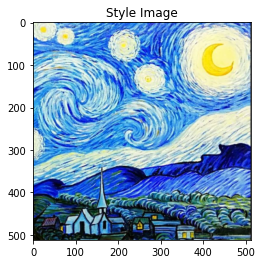

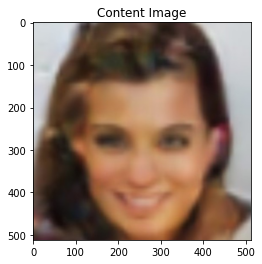

In [ ]:
unloader = transforms.ToPILImage()  # конвертируем в `PIL image`

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)      # убираем лишнюю размерность батча
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
#     plt.pause(0.001)


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

## Losses

In [ ]:
class ContentLoss(nn.Module):
    def __init__(self, target,):
        super().__init__()
        # detach() используется, чтобы не считать градиенты до target
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [ ]:
# upd: возможно, эта штука уже есть где-то в pytorch

def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [ ]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature, weight = 1.0):
        super().__init__()
        self.target = gram_matrix(target_feature).detach()
        self.weight = weight

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target) * self.weight
        return input

In [ ]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [ ]:
# upd: эта штука тоже уже должна быть где-нибудь в pytorch

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# Делаем модуль для нормализации, чтобы потом без труда стакать в слои
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [ ]:
# Какие именно слои мы хотим использовать чтобы считать наши лоссы
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # помним, что сначала нормализуем картинки
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # хотим иметь iterable с вставленными модулями
    content_losses = []
    style_losses = []

    # создаем свою модельку, в которую вставим лоссы
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # добавляем content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # добавляем style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # Обрезаем все слои, которые находятся после последнего ContentLoss или StyleLoss
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

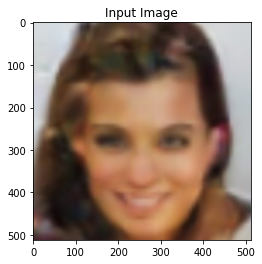

In [ ]:
input_img = content_img.clone()

# если есть желание подать шум, попробуйте эту строчку раскомментить
# input_img = torch.randn(content_img.data.size(), device=device)

plt.figure()
imshow(input_img, title='Input Image')

In [ ]:
def get_input_optimizer(input_img):
    # input_img - это параметры, до которых доходит градиент
    optimizer = optim.LBFGS([input_img.requires_grad_()]) # оптимизируем не веса модели, оптимизируем наше изображение, model params как обычно, а градиенты нашего изображения
    return optimizer

## Finally

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=320,
                       style_weight=1000000, content_weight=1): # отличаются на 6 порядков style > content
    """ Поехали! """
    
    print('Building the style transfer model..')
    # style_losses, content_losses - это и есть наши меры
    model, style_losses, content_losses = get_style_model_and_losses(cnn, normalization_mean,
                                                                     normalization_std,
                                                                     style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # корректируем значения, чтобы они лежали в пределах `[0..1]`
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # корректируем значения, чтобы они лежали в пределах `[0..1]` для финальной картинки
    input_img.data.clamp_(0, 1)

    return input_img

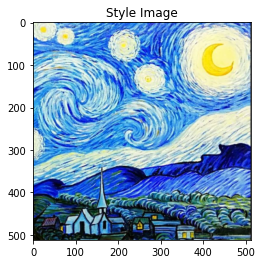

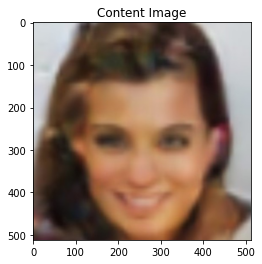

In [ ]:
plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

## Итоговый выход (FAKE FACE + STYLE TRANSFER)

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


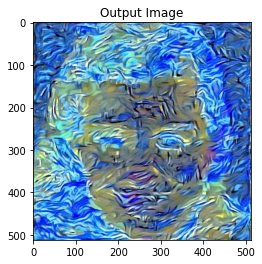

In [ ]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=1)

# plt.figure()
imshow(output, title='Output Image')
# plt.ioff()
plt.show()



In [ ]:
получилась какая-то синяя бестия)

# Clear

In [ ]:
# очистка памяти
del input_img
del content_img
del style_img
del cnn 
torch.cuda.empty_cache()



# Вывод:
Обучил DCGAN на лицах и применил Style Transfer в стиле Van Gogh’s Starry Night.

Дополнительно примененные техники улучшения стабильности гана:

1. AdamW для G и SGD для D.
2. Tanh as the last layer of the generator output
3. Использую dropout в G в train и test состояниях
4. другие трюки, которые упоминались в занятии и частично реализованы в исходном ноутбуке

На будущее:
1. Flip labels на каждой 100й эпохе для D
2. Техника из RL с возвратом на 1-4 эпохи назад с вероятностью 30%, отдельно для D и G 
3. Improved GANs, добавляю гауссовский шум на каждый слой G
4. Предобучил генератор

После генерации лиц применен Style Transfer: стиль Van Gogh’s Starry Night.